In [1]:
#Downloading the data
!wget https://cernbox.cern.ch/remote.php/dav/public-files/zUvpkKhXIp0MJ0g/top_gun_opendata_0.parquet
!wget https://cernbox.cern.ch/remote.php/dav/public-files/zUvpkKhXIp0MJ0g/top_gun_opendata_1.parquet

--2024-03-30 05:58:52--  https://cernbox.cern.ch/remote.php/dav/public-files/zUvpkKhXIp0MJ0g/top_gun_opendata_0.parquet
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 128.142.53.28, 128.142.53.35, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1171158319 (1.1G) [application/octet-stream]
Saving to: 'top_gun_opendata_0.parquet'

top_gun_opendata_0. 100%[===================>]   1.09G  20.8MB/s    in 56s     

2024-03-30 06:00:17 (20.0 MB/s) - 'top_gun_opendata_0.parquet' saved [1171158319/1171158319]

--2024-03-30 06:00:18--  https://cernbox.cern.ch/remote.php/dav/public-files/zUvpkKhXIp0MJ0g/top_gun_opendata_1.parquet
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.53.28, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1170397881 (1.1G) [application/

In [2]:
#Importing the necessary libraries
import torch
import torch.nn as nn
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import lr_scheduler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import os

In [3]:
#Setting up the environment
def setup_device():
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        if num_gpus <= 1:
            device = torch.device("cuda:0")
        else:
            device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

def setup_precision(mix_precision=False):
    if mix_precision:
        scaler = torch.cuda.amp.GradScaler()
    else:
        pass  

if __name__ == "__main__":
    device = setup_device()
    MIX = False  
    setup_precision(mix_precision=MIX)

In [4]:
#Processing the data
def process_data(file_path, chunk_size=4):
    datasets = []
    parquet_file = pq.ParquetFile(file_path)
    total_rows = parquet_file.metadata.num_rows
    for i in range(0, total_rows, chunk_size):
        chunk = parquet_file.read_row_group(i)
        dataset = chunk.to_pandas()
        condition = (dataset['m'].between(0, 255)) & (dataset['pt'].between(320, 1499))
        filtered_dataset = dataset[condition]
        if not filtered_dataset.empty:
            datasets.append(filtered_dataset)
    dataset = pd.concat(datasets, ignore_index=True)
    dataset["X_jet"] = dataset["X_jet"].apply(lambda data: np.array([np.stack(np.stack(data)[i], axis=-1) for i in range(4)]).reshape((125, 125, 4)))
    return dataset

parquet_file_path = '/kaggle/working/top_gun_opendata_0.parquet'
dataset = process_data(parquet_file_path)

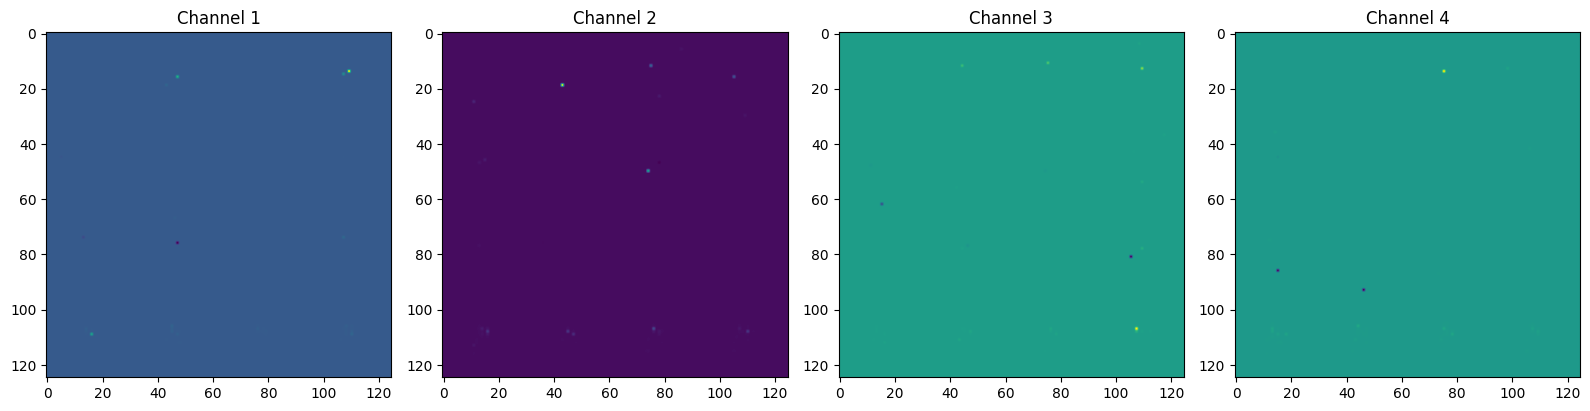

In [5]:
#Before processing
image_data = dataset["X_jet"][100]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  
for i in range(image_data.shape[2]):
    ax = axes[i]  
    channel_data = image_data[:, :, i]  
    ax.imshow(channel_data, cmap='viridis')  
    ax.set_title(f'Channel {i+1}') 
plt.tight_layout()  
plt.show()

In [6]:
#Process the images- MinMax scaling
def process_image(img):
    img[img < 1.e-3] = 0
    for c in range(img.shape[2]):  
        img[:, :, c] = (img[:, :, c] - img[:, :, c].mean()) / (img[:, :, c].std())
        channel = img[:, :, c]
        channel = np.clip(channel, 0, 500 * channel.std())
        channel = 255 * channel / channel.max()
        img[:, :, c] = channel
    img = img.astype(np.uint8)
    return img

for i in range(len(dataset)):
    for j in range(4):
        img = dataset["X_jet"][i][:, :, :j+1]  
        processed_img = process_image(img)
        dataset["X_jet"][i][:, :, :j+1] = processed_img

In [7]:
#Processing the data
def process_test_data(file_path, chunk_size=18):
    datasets = []
    parquet_file = pq.ParquetFile(file_path)
    total_rows = parquet_file.metadata.num_rows
    for i in range(0, total_rows, chunk_size):
        chunk = parquet_file.read_row_group(i)
        dataset = chunk.to_pandas()
        condition = (dataset['m'].between(0, 255)) & (dataset['pt'].between(320, 1499))
        filtered_dataset = dataset[condition]
        if not filtered_dataset.empty:
            datasets.append(filtered_dataset)
    dataset = pd.concat(datasets, ignore_index=True)
    dataset["X_jet"] = dataset["X_jet"].apply(lambda data: np.array([np.stack(np.stack(data)[i], axis=-1) for i in range(4)]).reshape((125, 125, 4)))
    return dataset

In [8]:
#TEST DATASET
parquet_file_path = '/kaggle/working/top_gun_opendata_1.parquet'
test_dataset = process_test_data(parquet_file_path)
for i in range(len(test_dataset)):
    for j in range(4):
        img = test_dataset["X_jet"][i][:, :, :j+1]  
        processed_img = process_image(img)
        test_dataset["X_jet"][i][:, :, :j+1] = processed_img

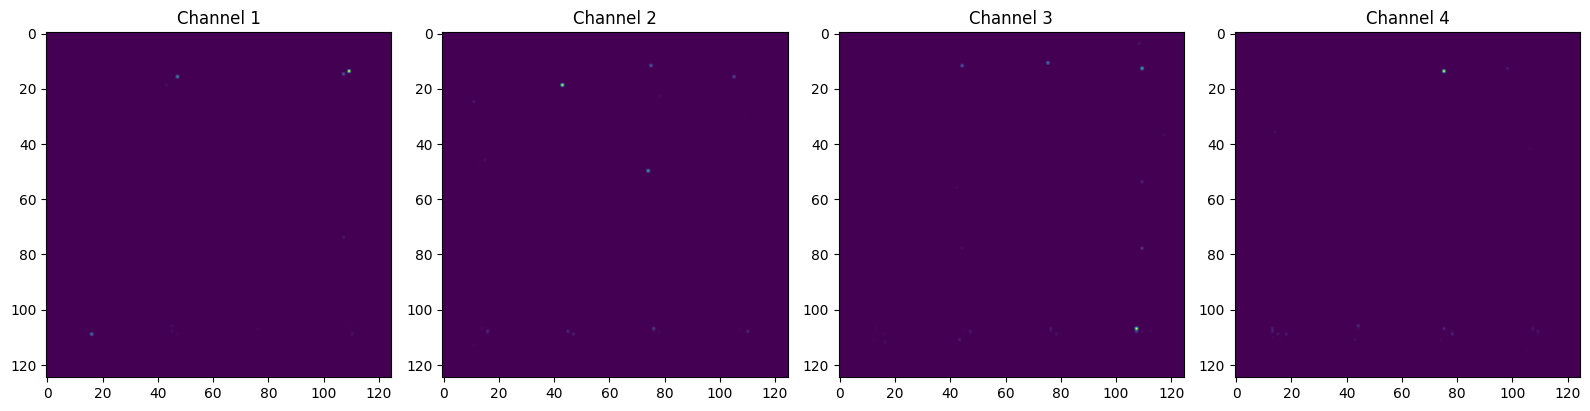

In [9]:
#After processing
image_data = dataset["X_jet"][100]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  
for i in range(image_data.shape[2]):
    ax = axes[i]  
    channel_data = image_data[:, :, i]  
    ax.imshow(channel_data, cmap='viridis')  
    ax.set_title(f'Channel {i+1}') 
plt.tight_layout()  
plt.show()

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

class Config:
    model_architecture = 'resnet'
    batch_capacity = 98
    learning_rate = 1e-5
    num_epochs = 25
    seed = 42
    num_classes = 3

    def __init__(self, train_dataset, val_dataset):
        self.train_data, self.val_data = train_test_split(train_dataset, test_size=0.2, random_state=self.seed)

        X_train_jets = np.stack(self.train_data['X_jet'].apply(np.concatenate).values)
        X_val_jets = np.stack(self.val_data['X_jet'].apply(np.concatenate).values)

        self.X_train = torch.tensor(X_train_jets, dtype=torch.float32).view(-1, 125, 125, 4)
        self.X_val = torch.tensor(X_val_jets, dtype=torch.float32).view(-1, 125, 125, 4)

        self.y_train = torch.tensor(pd.to_numeric(self.train_data['m']).values, dtype=torch.float32)
        self.y_val = torch.tensor(pd.to_numeric(self.val_data['m']).values, dtype=torch.float32)

        features_train = torch.stack([
            torch.tensor(self.train_data['ieta'].values, dtype=torch.float32),
            torch.tensor(self.train_data['iphi'].values, dtype=torch.float32),
            torch.tensor(self.train_data['pt'].values, dtype=torch.float32)
        ], dim=1)

        features_val = torch.stack([
            torch.tensor(self.val_data['ieta'].values, dtype=torch.float32),
            torch.tensor(self.val_data['iphi'].values, dtype=torch.float32),
            torch.tensor(self.val_data['pt'].values, dtype=torch.float32)
        ], dim=1)

        self.train_dataset = TensorDataset(self.X_train, features_train, self.y_train)
        self.val_dataset = TensorDataset(self.X_val, features_val, self.y_val)

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_capacity, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_capacity, shuffle=True)

settings = Config(train_dataset, val_dataset)
#Multimodal NN
class ConvolutionalModel(nn.Module):
    class Block(nn.Module):
        def __init__(self, in_planes, planes, stride=1):
            super(ConvolutionalModel.Block, self).__init__()
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(planes)

            self.shortcut = nn.Sequential()
            if stride != 1 or in_planes != planes:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes)
                )

        def forward(self, x):
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out += self.shortcut(x)
            out = F.relu(out)
            return out

    def __init__(self):
        super(ConvolutionalModel, self).__init__()
        self.in_planes = 64  
        self.conv1 = nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(self.Block, 64, 2, stride=1)
        self.layer2 = self._make_layer(self.Block, 128, 2, stride=2)
        self.layer3 = self._make_layer(self.Block, 256, 2, stride=2)

        self.fc = nn.Linear(256 * 16 * 16, 256)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class CombinedModel(nn.Module):
    def __init__(self, num_classes=1):
        super(CombinedModel, self).__init__()
        self.conv_model = ConvolutionalModel()
        self.nn_model = NeuralNetwork()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, images, features):
        conv_out = self.conv_model(images)
        nn_out = self.nn_model(features)
        combined = torch.cat((conv_out, nn_out), dim=1)
        combined = F.relu(self.fc1(combined))
        output = self.fc2(combined)
        return output.squeeze()

model_combined = CombinedModel().to(device)
if torch.cuda.device_count() > 1:
    model_combined = nn.DataParallel(model_combined)
model_combined = model_combined.to(device)
optimizer_combined = optim.Adam(model_combined.parameters(), lr=settings.learning_rate)
criterion_combined = nn.MSELoss()
scheduler_combined = CosineAnnealingLR(optimizer_combined, T_max=25, eta_min=1e-7)

In [11]:
train_losses_combined = []
val_losses_combined = []
mae_losses_combined = []
mre_losses_combined = []

best_val_loss_combined = float('inf')
best_mre_combined = float('inf')
best_val_loss_model_combined = None
best_mre_model_combined = None

for epoch in range(settings.num_epochs):
    model_combined.train()
    train_loss_combined = 0.0
    train_preds_list_combined = []

    train_batches = len(settings.train_loader)
    train_batch_size = settings.train_loader.batch_size
    
    print(f'Epoch {epoch + 1}/{settings.num_epochs}')
    for batch_idx, (images, features, labels) in enumerate(settings.train_loader):
        images, features, labels = images.to(device), features.to(device), labels.to(device)
        images = images.permute(0, 3, 1, 2)

        optimizer_combined.zero_grad()

        outputs_combined = model_combined(images, features)
        loss_combined = criterion_combined(outputs_combined, labels)
        loss_combined.backward()
        optimizer_combined.step()

        train_loss_combined += loss_combined.item()
        train_preds_list_combined.append(outputs_combined.detach().cpu().numpy())

        current_batch = min((batch_idx + 1) * train_batch_size, len(settings.train_loader.dataset))
        total_batches = len(settings.train_loader.dataset)
        progress = current_batch / total_batches
        progress_bar_length = 50
        completed_length = int(progress * progress_bar_length)
        remaining_length = progress_bar_length - completed_length
        arrow_position = int(progress_bar_length * progress)
        progress_bar = f'{current_batch}/{total_batches} ━' + '━' * completed_length + '┳' + '━' * remaining_length + '━'
        print(f'\r{progress_bar} {100 * progress:.2f}% Loss: {loss_combined.item():.2f}', end='', flush=True)
    print()
    
    train_loss_combined /= len(settings.train_loader)
    train_preds_combined = np.concatenate(train_preds_list_combined)

    model_combined.eval()
    val_loss_combined = 0.0

    val_batches = len(settings.val_loader)
    val_batch_size = settings.val_loader.batch_size

    print(f'Epoch {epoch + 1}/{settings.num_epochs}')
    for batch_idx, (images, features, labels) in enumerate(settings.val_loader):
        images, features = images.to(device), features.to(device)
        images = images.permute(0, 3, 1, 2)
        val_labels_combined = labels.to(device)
        val_outputs_combined = model_combined(images, features)
        val_loss_combined += criterion_combined(val_outputs_combined, val_labels_combined).item()

        # Custom progress bar
        current_batch = min((batch_idx + 1) * val_batch_size, len(settings.val_loader.dataset))
        total_batches = len(settings.val_loader.dataset)
        progress = current_batch / total_batches
        progress_bar_length = 50
        completed_length = int(progress * progress_bar_length)
        remaining_length = progress_bar_length - completed_length
        arrow_position = int(progress_bar_length * progress)
        progress_bar = f'{current_batch}/{total_batches} ━' + '━' * completed_length + '┳' + '━' * remaining_length + '━'
        print(f'\r{progress_bar} {100 * progress:.2f}%', end='', flush=True)
    print()

    val_loss_combined /= len(settings.val_loader)

    train_losses_combined.append(train_loss_combined)
    val_losses_combined.append(val_loss_combined)

    scheduler_combined.step(val_loss_combined)  # Step the LR scheduler

    if val_loss_combined < best_val_loss_combined:
        best_val_loss_combined = val_loss_combined
        best_val_loss_model_combined = model_combined.state_dict()

    print(f"Train Loss: {train_loss_combined:.4f}, Val Loss: {val_loss_combined:.4f}")

torch.save(best_val_loss_model_combined, 'weights.pth')
checkpoint_combined = torch.load("weights.pth")
model_combined = CombinedModel()
if torch.cuda.device_count() > 1:
    model_combined = nn.DataParallel(model_combined)
model_combined.load_state_dict(checkpoint_combined)
model_combined = model_combined.to(device)
model_combined.eval()

y_true_combined = []
y_pred_combined = []

with torch.no_grad():
    for images, features, target in settings.train_loader:
        images, features, target = images.to(device), features.to(device), target.to(device)
        images = images.permute(0, 3, 1, 2)
        output_combined = model_combined(images, features)
        y_true_combined.extend(target.cpu().numpy().tolist())
        y_pred_combined.extend(output_combined.cpu().numpy().tolist())

print(f"Average loss: {criterion_combined(torch.tensor(y_pred_combined), torch.tensor(y_true_combined))}")

model_combined.eval()
y_true_combined = []
y_pred_combined = []

with torch.no_grad():
    for batch_idx, (images, features, target) in enumerate(settings.val_loader):
        images, features, target = images.to(device), features.to(device), target.to(device)
        images = images.permute(0, 3, 1, 2)
        output_combined = model_combined(images, features)

        y_true_combined.extend(target.cpu().numpy().tolist())
        y_pred_combined.extend(output_combined.cpu().numpy().tolist())

Epoch 1/25
9798/9798 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00% Loss: 2858.03
Epoch 1/25
2450/2450 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00%
Train Loss: 11495.5599, Val Loss: 2536.4856
Epoch 2/25


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


9798/9798 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00% Loss: 2306.42
Epoch 2/25
2450/2450 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00%
Train Loss: 2461.4396, Val Loss: 2393.9893
Epoch 3/25
9798/9798 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00% Loss: 1934.74
Epoch 3/25
2450/2450 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00%
Train Loss: 2101.6415, Val Loss: 1868.6388
Epoch 4/25
9798/9798 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00% Loss: 1863.26
Epoch 4/25
2450/2450 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00%
Train Loss: 1829.6711, Val Loss: 1824.1108
Epoch 5/25
9798/9798 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00% Loss: 1724.86
Epoch 5/25
2450/2450 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00%
Train Loss: 1802.0264, Val Loss: 1822.2120
Epoch 6/25
9798/9798 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━ 100.00% Loss: 1523.56
Epoch 6/25
2450/2450 ━

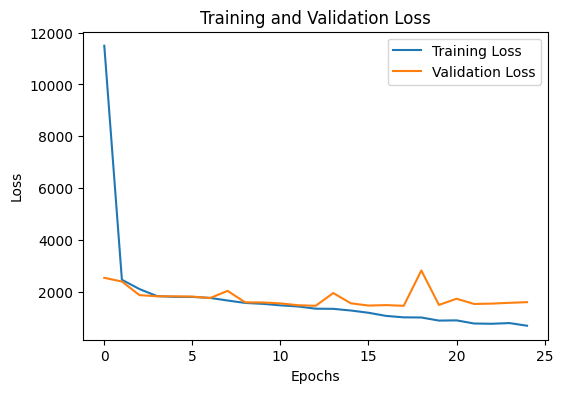

In [12]:
# Plotting training and validation loss curves
plt.figure(figsize=(6, 4))
plt.plot(train_losses_combined, label='Training Loss')
plt.plot(val_losses_combined, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
X_test_jets = np.stack(test_dataset['X_jet'].apply(np.concatenate).values)
X_test = torch.tensor(X_test_jets, dtype=torch.float32).view(-1, 125, 125, 4)

test_features = torch.stack([
    torch.tensor(test_dataset['ieta'].values, dtype=torch.float32),
    torch.tensor(test_dataset['iphi'].values, dtype=torch.float32),
    torch.tensor(test_dataset['pt'].values, dtype=torch.float32)
], dim=1)

test_labels = torch.tensor(pd.to_numeric(test_dataset['m']).values, dtype=torch.float32)
test_dataset = TensorDataset(X_test, test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=settings.batch_capacity, shuffle=False)

model_combined = CombinedModel()
if torch.cuda.device_count() > 1:
    model_combined = nn.DataParallel(model_combined)
model_combined.load_state_dict(checkpoint_combined)
model_combined = model_combined.to(device)
model_combined.eval()

predictions = []
true_labels = []
with torch.no_grad():
    for images, features, labels in test_loader:
        images, features = images.to(device), features.to(device)
        images = images.permute(0, 3, 1, 2)
        outputs = model_combined(images, features)
        predictions.extend(outputs.cpu().numpy().tolist())
        true_labels.extend(labels.cpu().numpy().tolist())

mse = mean_squared_error(true_labels, predictions)
print(f"Mean Squared Error (MSE) on test dataset: {mse}")
mae = mean_absolute_error(true_labels, predictions)
print(f"Mean Absolute Error (MAE) on test dataset: {mae}")

Mean Squared Error (MSE) on test dataset: 1626.389115844128
Mean Absolute Error (MAE) on test dataset: 32.22285861178238
